In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf

# Data Description


In [2]:
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
#Droping Unnamed: 0 col as it doesn't have any role in data
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Clothing ID,23486.0,918.118709,203.298980,0.0,861.0,936.0,1078.0,1205.0
Age,23486.0,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Recommended IND,23486.0,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,23486.0,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


In [6]:
df.nunique()

Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

In [7]:
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [8]:
# Counting Unique value and Missing value and embedding into one table for better understanding.

unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])
pd.DataFrame(unique_count, columns=['Column', 'Unique', 'Missing']).set_index('Column')


,Unique,Missing
Column,,
Clothing ID,1206,0
Age,77,0
Title,13994,3810
Review Text,22635,845
Rating,5,0
Recommended IND,2,0
Positive Feedback Count,82,0
Division Name,4,14
Department Name,7,14


Dropping the null value and then checking the shape of the dataset. Before dropping null values dataset has 23486 rows & 10 Col and after dropping we have 19662 rows & 10 Col.

In [9]:
df = df.dropna()
df.shape

(19662, 10)

In [10]:
df_numerical = df.select_dtypes(include=['int64'])
df_categorical = df.select_dtypes(include=['object'])
df_cat = df[['Division Name', 'Department Name','Class Name']]

print("Numerical col: ", df_numerical.columns)
print("categorical col:", df_categorical.columns)
print("Object col: ", df_cat.columns)

Numerical col:  Index(['Clothing ID', 'Age', 'Rating', 'Recommended IND',
       'Positive Feedback Count'],
      dtype='object')
categorical col: Index(['Title', 'Review Text', 'Division Name', 'Department Name',
       'Class Name'],
      dtype='object')
Object col:  Index(['Division Name', 'Department Name', 'Class Name'], dtype='object')


correlation for each feature with the help of a heatmap

Text(0.5, 1.0, 'Heatmap for Whole Data')

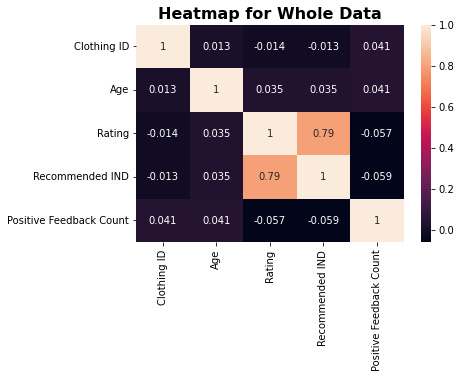

In [11]:
sns.heatmap(df.corr(), annot=True) 
plt.title('Heatmap for Whole Data', fontsize = 16, fontweight = 'bold')

In [12]:
df.head().style.background_gradient(cmap="Pastel1")


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",2,0,4,General,Dresses,Dresses
6,858,39,Cagrcoal shimmer fun,"I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bummer, no petite). i decided to jkeep it though, because as i said, it matvehd everything. my ejans, pants, and the 3 skirts i waas trying on (of which i ]kept all ) oops.",5,1,1,General Petite,Tops,Knits


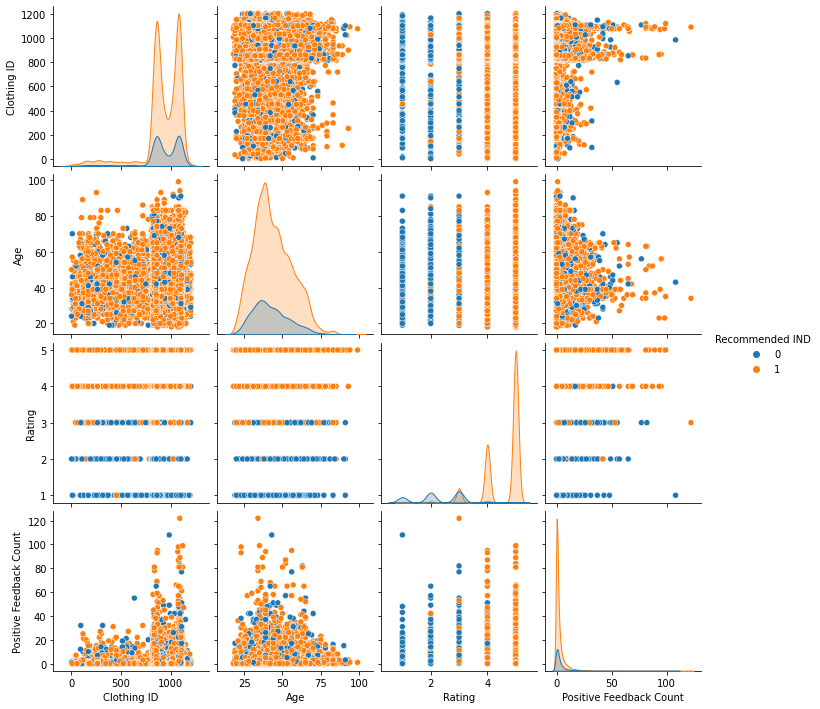

In [13]:
sns.pairplot(df, hue='Recommended IND')


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

In [15]:
#df.loc[df['Recommended IND'] == 0, 'Recommended IND'] = 'Not Recommended'
#df.loc[df['Recommended IND'] == 1, 'Recommended IND'] = 'Recommended'
#df.head()

In [16]:
data_recommended = df[df['Recommended IND'] == 1]  # Dataframe that only includes recommended reviews
data_not_recommended = df[df['Recommended IND'] == 0] 

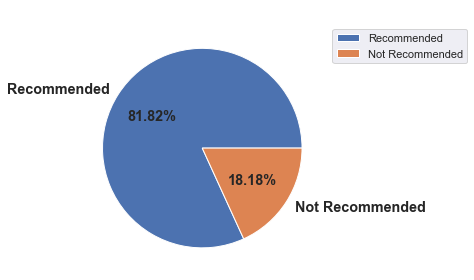

In [17]:
plt.figure(figsize = (6,4))
x = df['Recommended IND'].value_counts()
labels = 'Recommended','Not Recommended'
plt.pie(x = x,  labels = labels,
        autopct = '%.2f%%', 
        textprops = {'size' : 'x-large',
                   'fontweight' : 'bold'})
plt.title('Distribution of Recomended ID', fontsize = 14, fontweight = 'bold', color='white')
plt.legend(labels, loc="upper left", bbox_to_anchor = (1,1))
plt.tight_layout()
plt.show()

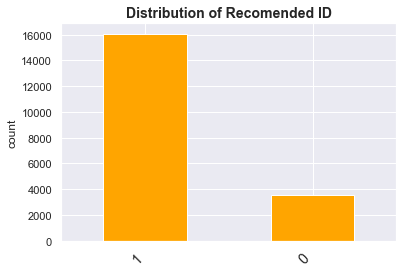

In [18]:
df['Recommended IND'].value_counts()[:].plot(kind='bar', color='orange')
df['Recommended IND'].value_counts()
plt.title('Distribution of Recomended ID', fontsize = 14, fontweight = 'bold')
plt.ylabel('count')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')
plt.show()



82% of the data we have been recommended to customers means the data is of good quality.

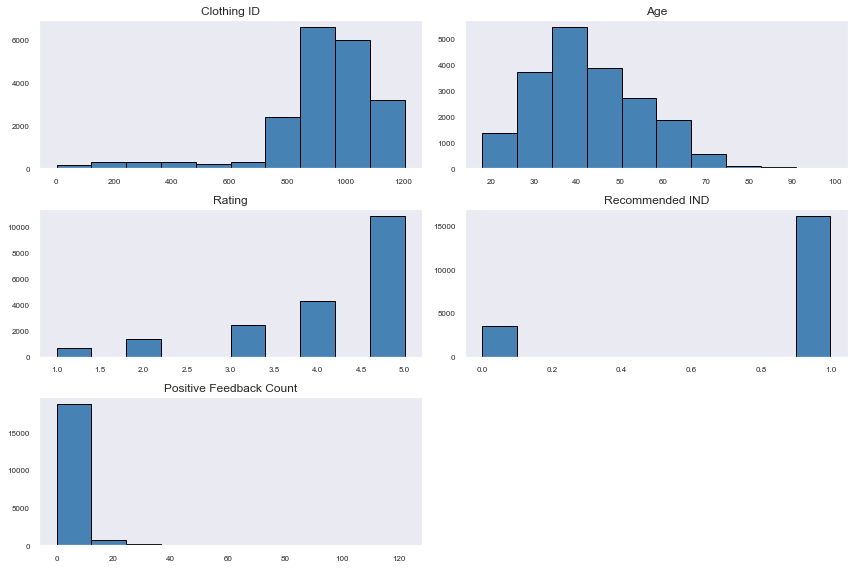

In [19]:
# visualization for numerical data

df.hist(bins=10, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 2, 2))

As we take a look at the graph Clothing Id has way more skewness.

Age has skewness and how come 99 year old people give ratings. So I might think they gave false age.

Rating we do have a product that has fewer ratings but mostly data is in 5 ratings.

Recommended IND Mostly product is Recommended to customer

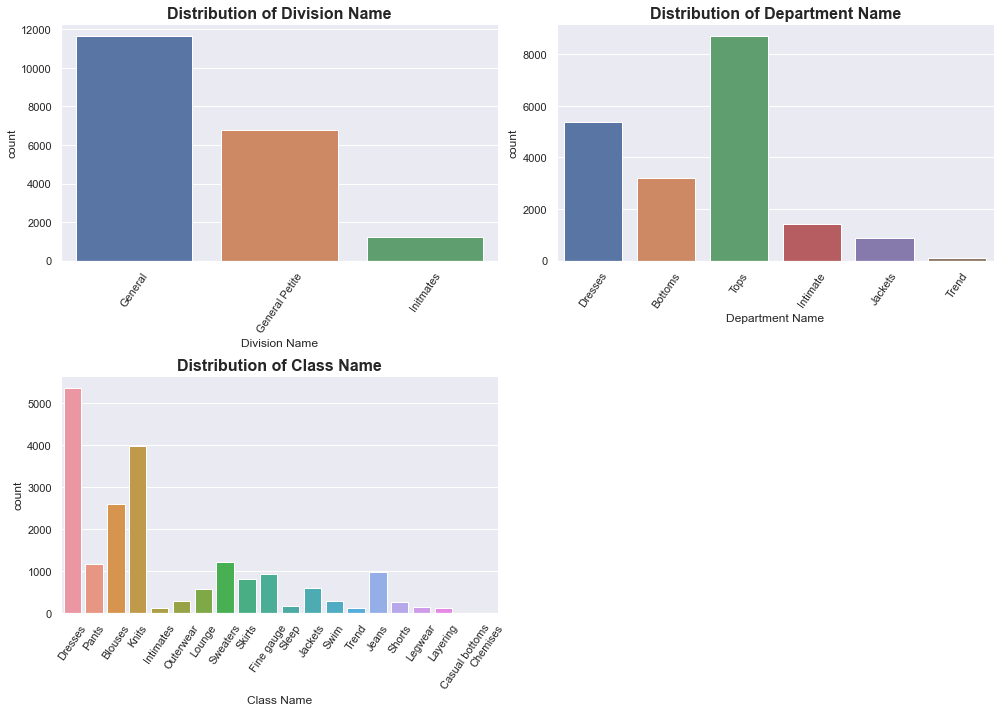

In [20]:
# Visualization for categorical data

plt.figure(figsize=[14,10])
n = 1
for x in df_cat:
    plt.subplot(2,2,n)
    sns.countplot(x=df[x],data=df)
    sns.despine()
    plt.title("Distribution of {}".format(x), fontsize=16, fontweight='bold')
    plt.xticks(rotation=55)
    n=n+1
plt.tight_layout()
plt.show()

Division Name: General products are more in demand than intimate products

Department Name: Most choose products are Tops & Dresses

Class Name: Dresses, Knits, and Blouses are the most popular

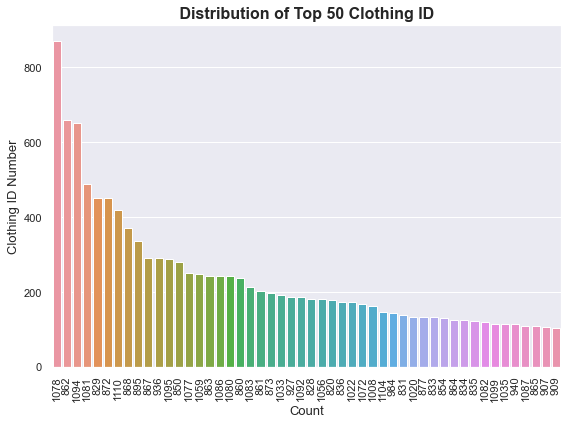

In [21]:
# Univariate distribution of clothing ID

plt.figure(figsize=(8,6))
ax = sns.countplot(x='Clothing ID', data=df, order=df['Clothing ID'].value_counts().index[:50])

plt.title(' Distribution of Top 50 Clothing ID ', fontsize = 16, fontweight = 'bold')
plt.xlabel('Count', fontsize=13)
plt.xticks(rotation=90)
plt.ylabel('Clothing ID Number', fontsize=13)
plt.tight_layout()

## Bivariate Visualization
#### Division, Department & Class Name Vs Recommended IND


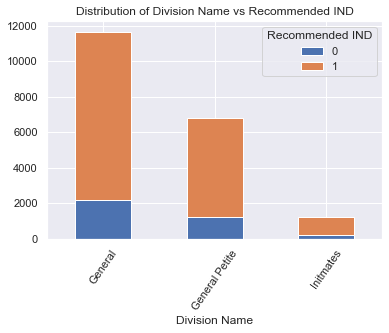

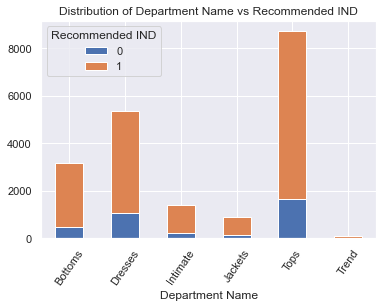

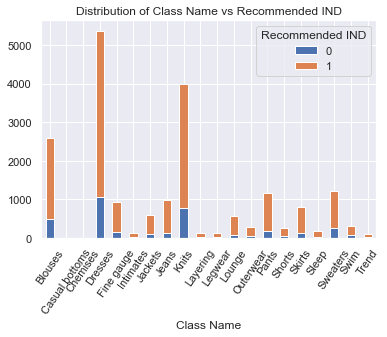

In [22]:
for x in df_cat:
    y = pd.crosstab(df[x], df['Recommended IND'])
    y.div(y.sum(1).astype(float), axis=0)
    y.plot(kind='bar', stacked=True)
    plt.title("Distribution of {} vs Recommended IND".format(x))
    plt.xticks(rotation=55)

#### Age, Positive Feedback Count Vs Recommended IND


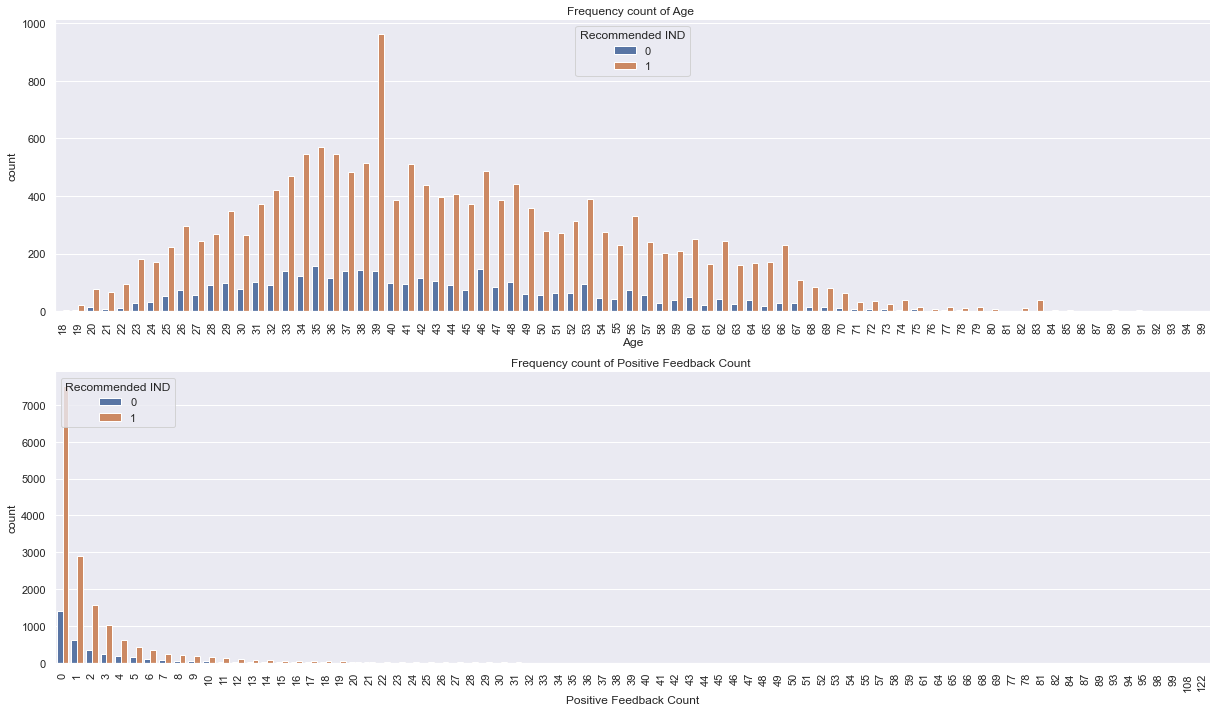

In [23]:
plt.figure(figsize=[17,10])
n = 1
label = df[['Age', 'Positive Feedback Count']]
for x in label:
    plt.subplot(2,1,n)
    sns.countplot(x=df[x], hue='Recommended IND', data=df)
    sns.despine()
    plt.title("Frequency count of {} ".format(x))
    plt.xticks(rotation=90)
    n=n+1
plt.tight_layout()
plt.show()

#### Division, Department & Class Name Vs Rating


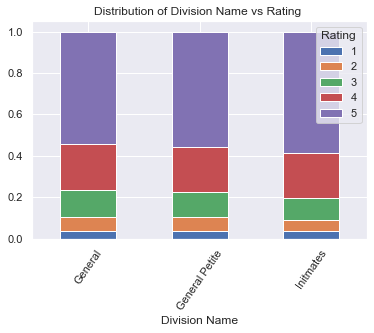

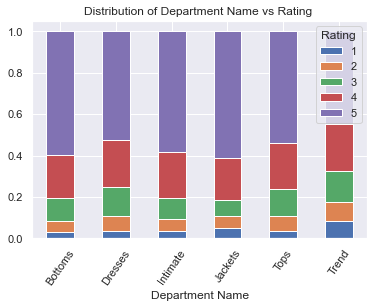

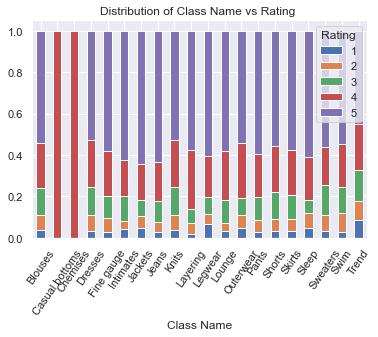

In [24]:
for x in df_cat:
    y = pd.crosstab(df[x], df['Rating'])
    y.div(y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title("Distribution of {} vs Rating ".format(x))
    plt.xticks(rotation=55)

#### Division, Department & Class Name Vs Rating


Text(0.5, 1.0, 'Age vs Rating')

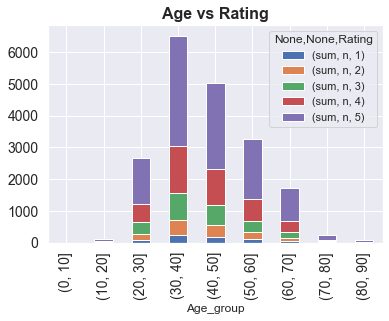

In [25]:
df1 = df.copy()
bins = np.arange(0,100,10)
df1['Age_group'] = pd.cut(df1['Age'], bins)
df1 = df1.groupby(['Rating', df1['Age_group']]).size().reset_index(name='n')
df1.columns

ratings_count_df_pivot = pd.pivot_table(df1,index=["Age_group"],
               values=["n"],
               columns=["Rating"],
               aggfunc=[np.sum])
ratings_count_df_pivot.plot(kind = 'bar', stacked=True, fontsize = 14)
plt.title('Age vs Rating', fontweight='bold', fontsize = 16)

#### Division, Department & Class Name Vs Age


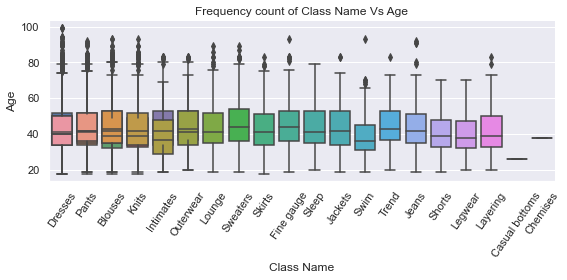

In [26]:
plt.figure(figsize=[8,10])
n = 1
for x in df_cat:
    plt.subplot(3,1,n)
    sns.boxplot(x=df[x], y='Age',data=df)
    sns.despine()
    plt.title("Frequency count of {} Vs Age".format(x))
    plt.xticks(rotation=55)
plt.tight_layout()
plt.show()

#### Division, Department & Class Name Vs Division, Department & Class Name


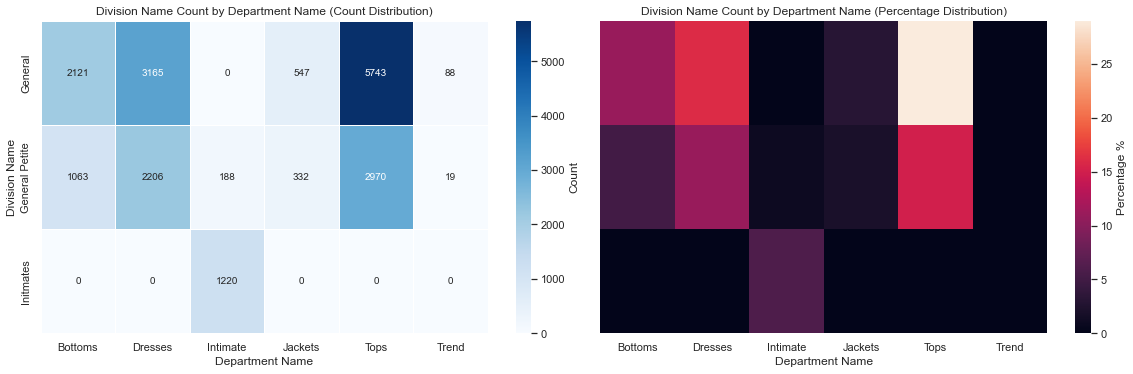

In [27]:
f, ax = plt.subplots(1,2, figsize=(16,5), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
            cbar_kws={'label': 'Count'})

ax[0].set_title('Division Name Count by Department Name (Count Distribution)')
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], 
            normalize=True).mul(100).round(0), 
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name (Percentage Distribution)')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()


cgar_kws = is used for labeling y labels.

normalize = True means normalizing overall values.

For more information visit pandas official website.

https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

The dominance of the General size is more across the various categories within Department Name. There a notable overall between General Petite and Department Name.

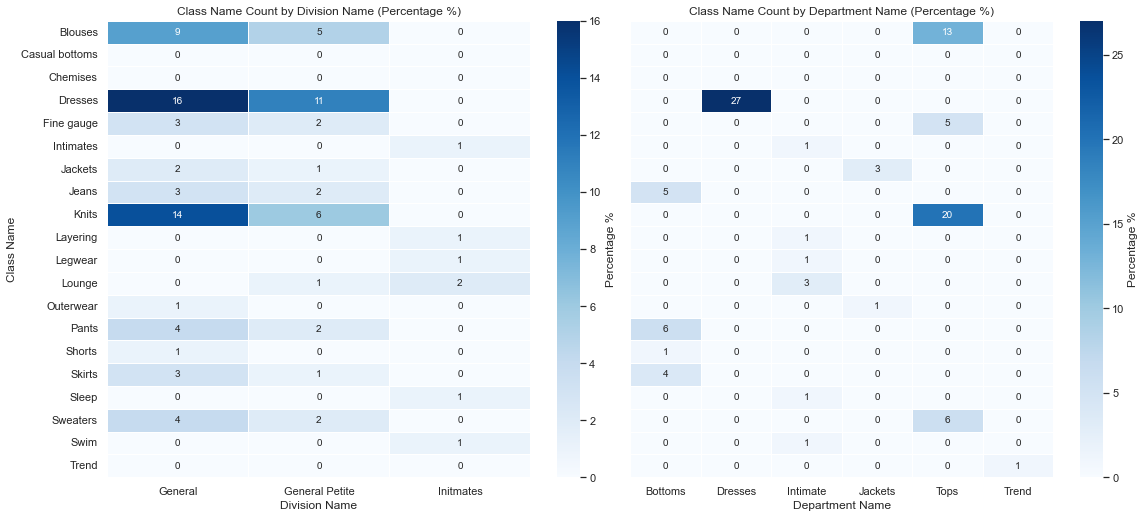

In [28]:
f, ax = plt.subplots(1,2,figsize=(16,7), sharey=True)
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
            cbar_kws={'label': 'Percentage %'})

ax[0].set_title('Class Name Count by Division Name (Percentage %)')
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Blues",
            cbar_kws={'label': 'Percentage %'})

ax[1].set_title('Class Name Count by Department Name (Percentage %)')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

We have seen that dress's popularity is way more but not that of knits.

Up til now, we have seen basic manipulation and Univarient and Bivarient visualization for some insights

In [29]:
pd.set_option('max_colwidth', 500)
df[['Title','Review Text']].head(3)

,Title,Review Text
2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ..."
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!


# CLean Text


In [30]:
# Dropping the missing values in the rows
df = df.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'], axis=0)
df = df.reset_index(drop=True)

# Checking for the missing values after the drops
count_NaN_updated = df.isna().sum()
count_NaN_updated

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [31]:
df['Review Text'] = df['Review Text'].str.lower()
df['Review Text'].head()

0    i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...
1                                                                                                                                                                                                                                                                                                                                                                                           i love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great com

In [32]:
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


df['Review Text'] = df['Review Text'].apply(remove_punctuations_numbers)

In [33]:
def tokenization(inputs):  # Ref.1
    return word_tokenize(inputs)


df['text_tokenized'] = df['Review Text'].apply(tokenization)
df['text_tokenized'].head()

0    [i, had, such, high, hopes, for, this, dress, and, really, wanted, it, to, work, for, me, i, initially, ordered, the, petite, small, my, usual, size, but, i, found, this, to, be, outrageously, small, so, small, in, fact, that, i, could, not, zip, it, up, i, reordered, it, in, petite, medium, which, was, just, ok, overall, the, top, half, was, comfortable, and, fit, nicely, but, the, bottom, half, had, a, very, tight, under, layer, and, several, somewhat, cheap, net, over, layers, imo, a, maj...
1                                                                                                                                                                                                                                                                                                                                                                           [i, love, love, love, this, jumpsuit, it, s, fun, flirty, and, fabulous, every, time, i, wear, it, i, get, nothing, but, great, com

In [34]:
# Stopwords Removal

stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):  # Ref.2
    return [k for k in inputs if k not in stop_words]


df['text_stop'] = df['text_tokenized'].apply(stopwords_remove)
df['text_stop'].head()

0    [high, hopes, dress, really, wanted, work, initially, ordered, petite, small, usual, size, found, outrageously, small, small, fact, could, not, zip, reordered, petite, medium, ok, overall, top, half, comfortable, fit, nicely, bottom, half, tight, layer, several, somewhat, cheap, net, layers, imo, major, design, flaw, net, layer, sewn, directly, zipper, c]
1                                                                                                                                                                                                                                                                 [love, love, love, jumpsuit, fun, flirty, fabulous, every, time, wear, get, nothing, great, compliments]
2                                                                                                                                                                                                                                        [shirt, flattering, due, adjustable, fron

In [35]:
# Lemmatization

lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]

df['text_lemmatized'] = df['text_stop'].apply(lemmatization)
df['text_lemmatized'].head()

0    [high, hop, dress, really, want, work, initially, order, petite, small, usual, size, find, outrageously, small, small, fact, could, not, zip, reorder, petite, medium, ok, overall, top, half, comfortable, fit, nicely, bottom, half, tight, layer, several, somewhat, cheap, net, layer, imo, major, design, flaw, net, layer, sew, directly, zipper, c]
1                                                                                                                                                                                                                                                       [love, love, love, jumpsuit, fun, flirty, fabulous, every, time, wear, get, nothing, great, compliment]
2                                                                                                                                                                                                                                 [shirt, flatter, due, adjustable, front, tie, perfect, length, wear, l

In [36]:
# Removing Words less than length 2

def remove_less_than_2(inputs):
    return [j for j in inputs if len(j) > 2]
df['final'] = df['text_lemmatized'].apply(remove_less_than_2)

In [37]:
df['final'] = df['final'].str.join(' ')
df['final'].head()

0    high hop dress really want work initially order petite small usual size find outrageously small small fact could not zip reorder petite medium overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sew directly zipper
1                                                                                                                                                                                                               love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
2                                                                                                                                                                                           shirt flatter due adjustable front tie perfect length wear leggings sleeveless pair well cardigan love shirt
3                                love tracy reese dress one not petite feet tall usually wear brand dress pre

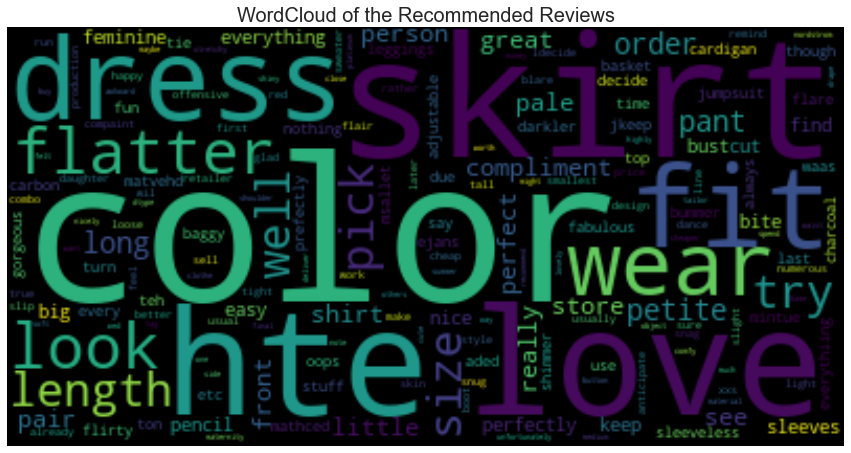

In [38]:
data_recommended = df[df['Recommended IND'] == 1]  # Dataframe that only includes recommended reviews
data_not_recommended = df[df['Recommended IND'] == 0]  # # Dataframe that only includes not recommended reviews

WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((data_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

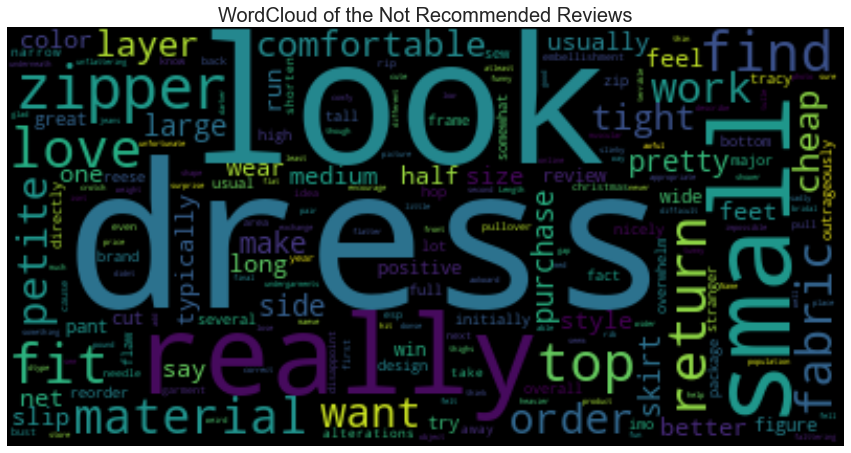

In [39]:
WordCloud_not_recommended = WordCloud(max_words=500, 
                                      random_state=30, 
                                      collocations=True).generate(str((data_not_recommended['final'])))
plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_not_recommended, interpolation='bilinear')
plt.title('WordCloud of the Not Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

# Train-Test-Validation Split


In [40]:
y = df['Recommended IND']
X = df['final']

X.head()

0    high hop dress really want work initially order petite small usual size find outrageously small small fact could not zip reorder petite medium overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sew directly zipper
1                                                                                                                                                                                                               love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
2                                                                                                                                                                                           shirt flatter due adjustable front tie perfect length wear leggings sleeveless pair well cardigan love shirt
3                                love tracy reese dress one not petite feet tall usually wear brand dress pre

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Tokenizing with Tensorflow

In [42]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_test)

print('Non-tokenized Version: ', X_train[80])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[80]]))

Non-tokenized Version:  buy lovely silk velvet shirt quot sky quot color teal blue side sky blue disappoint definitely darker appear photo still luxurious well make beauty sassy appeal drape like snake slither body come attitude
Tokenized Version:  [[19, 132, 507, 803, 30, 1868, 1356, 1868, 11, 800, 99, 107, 1356, 99, 172, 106, 563, 333, 189, 71, 1211, 27, 18, 839, 2559, 925, 191, 10, 3940, 8961, 117, 112, 2573]]


### Padding the Datasets


In [43]:
maxlen = 50
padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

# Model Creation

In [44]:
model = Sequential()

model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))

model.add(GlobalAvgPool1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
optimizer = tf.optimizers.Adam(lr=0.55e-3)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

c:\Users\GAMER\anaconda3\envs\Machinelearning\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
# Training the Model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='auto', 
                                                  patience=5, 
                                                  restore_best_weights=True)

epochs = 100
history = model.fit(padded_train, y_train, epochs=epochs, 
                    validation_data=(padded_val, y_test), 
                    callbacks=[early_stopping], batch_size=32)

Epoch 1/100
492/492 [==============================] - 1s 1ms/step - loss: 0.5612 - accuracy: 0.8077 - val_loss: 0.4713 - val_accuracy: 0.8180
Epoch 2/100
492/492 [==============================] - 1s 1ms/step - loss: 0.4628 - accuracy: 0.8182 - val_loss: 0.4466 - val_accuracy: 0.8180
Epoch 3/100
492/492 [==============================] - 1s 1ms/step - loss: 0.4428 - accuracy: 0.8182 - val_loss: 0.4286 - val_accuracy: 0.8180
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4206 - accuracy: 0.8182 - val_loss: 0.4086 - val_accuracy: 0.8180
Epoch 5/100
492/492 [==============================] - 1s 1ms/step - loss: 0.3987 - accuracy: 0.8186 - val_loss: 0.3870 - val_accuracy: 0.8182
Epoch 6/100
492/492 [==============================] - 1s 1ms/step - loss: 0.3741 - accuracy: 0.8217 - val_loss: 0.3648 - val_accuracy: 0.8225
Epoch 7/100
492/492 [==============================] - 1s 1ms/step - loss: 0.3496 - accuracy: 0.8326 - val_loss: 0.3442 - val_accuracy: 0.8340

## Train and Validation Loss Graphs


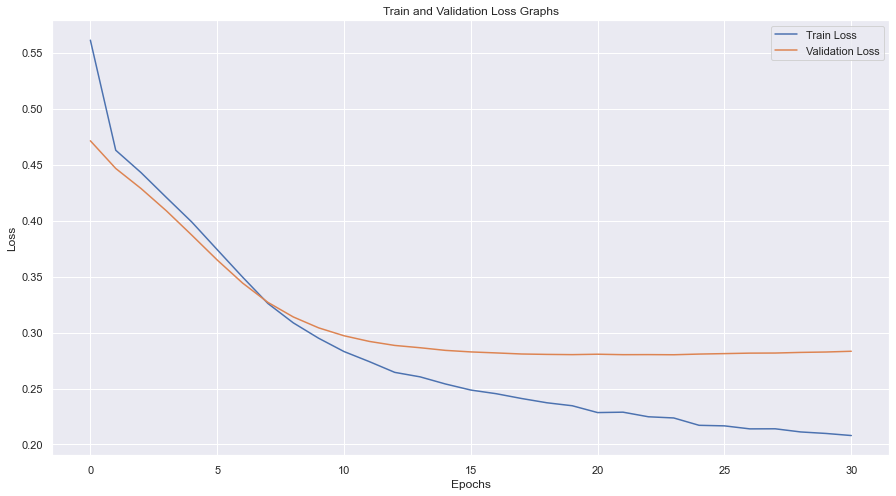

In [46]:
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Train and Validation Accuracy Graphs

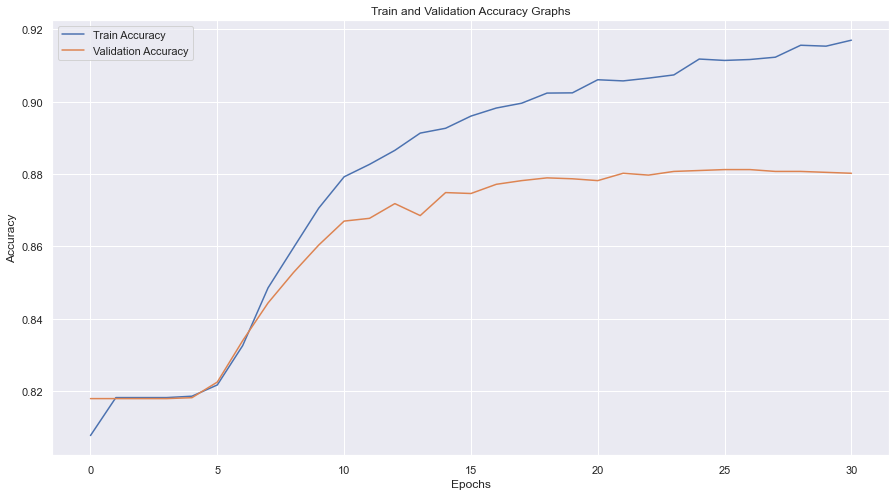

In [47]:
plt.figure(figsize=(15, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Preparing the Test Data


In [48]:
X_test = X_test.apply(tokenization)
X_test = X_test.apply(stopwords_remove)
X_test = X_test.apply(lemmatization)
X_test = X_test.str.join(' ')

X_test.head()

12964                                                                              receive dress color oatmeal blue christmas love super comfortable great leggings wear lounge around house dress bite church lbs get small fit true size would definitely recommend
12795                                                                                                          love dress however broad shoulder need size would say straight slender frame tts bottam half fine tad bite snug around arm pit cute spring summer sell
6945                                                                  lace fit good length seem awkward give boxy flowy ish dress felt like baby doll sleeves something hat outside middle material hat felt cheap odd compare lace maybe not right demographic piece
18494    dress beautiful purchase teal bead hem bead subtle beautiful wear spring wed even though believe would best cooler months want plum option flower aplique hem perfect spring wed note teal bead bead weigh bi

In [49]:
Tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

test_evaluate = model.evaluate(padded_test, y_test)

123/123 [==============================] - 0s 423us/step - loss: 0.2812 - accuracy: 0.8813


# Confusion Matrix of the Test Data

In [50]:
pred_train_lstm = model.predict(padded_train)
pred_test_lstm = model.predict(padded_test)

In [51]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm):
    if 0 <= x < 0.49:
        pred_train_lstm[i] = 0
    else:
        pred_train_lstm[i] = 1

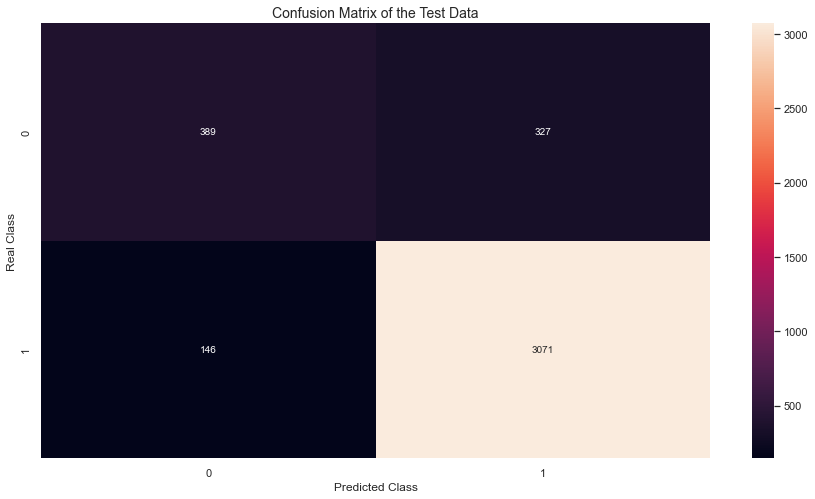

In [53]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# Evaluation Metrics of the LSTM Model

### Accuracy

In [54]:
train_acc_lstm = round(accuracy_score(y_train, pred_train_lstm) * 100, 2)
print('Train Accuracy of the LSTM: %', train_acc_lstm)
test_acc_lstm = round(accuracy_score(y_test, pred_test_lstm) * 100, 2)
print('Test Accuracy of the LSTM: %', test_acc_lstm)

Train Accuracy of the LSTM: % 91.39
Test Accuracy of the LSTM: % 87.97


### Precision


In [55]:
train_precision_lstm = round(precision_score(y_train, pred_train_lstm) * 100, 2)
print('Train Precision of the LSTM: %', train_precision_lstm)
precision_lstm = round(precision_score(y_test, pred_test_lstm) * 100, 2)
print('Test Precision of the LSTM: %', precision_lstm)

Train Precision of the LSTM: % 92.98
Test Precision of the LSTM: % 90.38


### Recall


In [56]:
train_recall_lstm = round(recall_score(y_train, pred_train_lstm) * 100, 2)
print('Train Recall of the LSTM: %', train_recall_lstm)
recall_lstm = round(recall_score(y_test, pred_test_lstm) * 100, 2)
print('Test Recall of the LSTM: %', recall_lstm)

Train Recall of the LSTM: % 96.79
Test Recall of the LSTM: % 95.46


# Predict Recommendation

In [59]:
def predict_recommendation(input_text):
    input_text = input_text.lower()
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = tokenization(input_text)
    input_text = stopwords_remove(input_text)
    input_text = lemmatization(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=maxlen, padding='pre')
    input_text = model.predict(input_text)

    if input_text >= 0.5:
        input_text = f'Recommended with %{round(float(input_text * 100), 2)}'
    else:
        input_text = f'Not Recommended with %{round(float(input_text * 100), 2)}'
    
    return print(input_text)

In [60]:
predict_recommendation("The clothes are such poor quality and look nothing like they do on the website. I order 2 packages of fast fashion a year just as a treat, and I sorely regret buying from here. Fabrics are cheaper than what they charge, their seems to be no thought of sizing consitency and so on")

Not Recommended with %23.41


In [61]:
predict_recommendation("Beautiful colour of lemon great fit and length here in three days all l need is some fine weather to show if at it's best!!!!!")

Recommended with %97.21


In [62]:
predict_recommendation("As usual the clothes I ordered arrived quickly and were all a good fit, except for yoga pants , had to cit 4 ins off them but they are lovely pants. I shall wait for my next pay day!!")

Recommended with %84.97


In [63]:
predict_recommendation("I should've checked reviews before ordering... each item they sent was much worse quality in person than how it appeared online, and one of the dresses looked NOTHING in person what they said it was! I even double-checked to make sure they didn't accidentally send me the wrong item. see photos below.")

Not Recommended with %6.14


In [64]:
predict_recommendation("cheap material that falls apart in seconds. Clothes look nothing like the pictures. I bought the chunky heeled shoes they broke after two times of wearing them.")

Not Recommended with %35.28


In [65]:
predict_recommendation("Very fast dispatch and delivery. Clothes are always a consistent fit, good quality and well priced. Couldn't ask for more! Will be using again and would happily recommend.")

Recommended with %77.13
